In [1]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd
import networkx as nx
from multiprocessing.pool import Pool
from rdkit.Chem.rdchem import BondType
import os
import matplotlib.pylab as plt

In [2]:
def GetNBEandGapEnergy(mols, smiles_list, res_error='results/all_gapenergy_error.txt',):
    res_error = open(res_error,'a')
    descs = [desc_name[0] for desc_name in Descriptors._descList]
    desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)
    atoms = [['H', 'H'], ['H', 'F'], ['H', 'Cl'], ['H', 'Br'], ['H', 'I'],
             ['C', 'H'], ['C', 'C'], ['C', 'N'], ['C', 'O'], ['C', 'F'], ['C', 'Cl'], ['C', 'Br'], ['C', 'I'], ['C', 'S'],
             ['N', 'H'], ['N', 'N'], ['N', 'F'], ['N', 'Cl'], ['N', 'Br'], ['N', 'O'],
             ['O', 'H'], ['O', 'O'], ['O', 'F'], ['O', 'Cl'], ['O', 'I'],
             ['F', 'F'], ['F', 'Cl'], ['F', 'Br'], ['Cl', 'Cl'], ['Cl', 'Br'], ['Br', 'Br'], ['I', 'I'], ['I', 'Cl'], ['I', 'Br'],
             ['S', 'H'], ['S', 'F'], ['S', 'Cl'], ['S', 'Br'], ['S', 'S'],
             ['Si', 'Si'], ['Si', 'H'], ['Si', 'C'], ['Si', 'O'],
             ['C', 'C'], ['C', 'C'], ['O', 'O'], ['C', 'O'], ['C', 'O'], ['N', 'O'], ['N', 'N'],
             ['N', 'N'], ['C', 'N'], ['C', 'N'],
             ['P', 'H'], ['P', 'Cl'], ['P', 'Br'], ['P', 'O'], ['P', 'O'], ['P', 'P'], ['P', 'C'],
             ['S', 'C'], ['S', 'O'], ['S', 'O'],
             ['S','N'], ['S','P'], ['S','P']]
    bondtypes = [BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, # 5
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #9
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #6
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #5
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #9
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #5
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, #4
                 BondType.DOUBLE, BondType.TRIPLE, BondType.DOUBLE, BondType.DOUBLE, BondType.TRIPLE, BondType.DOUBLE, BondType.DOUBLE, #7
                 BondType.TRIPLE, BondType.TRIPLE, BondType.DOUBLE, #3
                 BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.SINGLE, BondType.DOUBLE, BondType.SINGLE, BondType.SINGLE, #7
                 BondType.DOUBLE, BondType.SINGLE, BondType.DOUBLE, #3
                 BondType.SINGLE, BondType.SINGLE, BondType.DOUBLE #3
                 ]
    energies = [432, 565, 427, 363, 295, 413, 347, 305, 358, 485, 339, 276, 240, 259, 391, 160, 272, 200, 243, 201, 467,
                146, 190, 203, 234,
                154, 253, 237, 239, 218, 193, 149, 208, 175, 347, 327, 253, 218, 266, 340, 393, 360, 452, 614, 839, 495,
                745, 1072, 607, 418,
                941, 891, 615, 322, 331, 272, 410, 585, 213, 305, 536, 226, 460,
                121, 463, 389]
    # 键长参考https://wenku.baidu.com/view/d9284346767f5acfa1c7cd42.html#opennewwindow
    # http://www.wiredchemist.com/chemistry/data/bond_energies_lengths.html
    # https://cccbdb.nist.gov/calcbondcomp2.asp?i=7&j=35
    ExactbondWet = [2.015650064, 20.006228252, 35.976677712, 79.926162132, 127.912298032, 13.007825032, 24.0,
                    26.003073999999998, 27.99491462, 30.99840322, 46.96885268,
                    90.9183371, 138.904473, 43.972071, 15.010899032, 28.006148, 33.00147722, 48.971926679999996,
                    92.9214111, 29.99798862, 17.002739652, 31.98982924,
                    34.99331784, 50.9637673, 142.89938762, 37.99680644, 53.9672559, 97.91674032, 69.93770536,
                    113.88718978, 157.8366742, 253.808946,
                    161.87332568, 205.8228101, 32.979896032, 50.97047422, 66.94092368, 110.8904081, 63.944142,
                    55.95385306, 28.984751562, 39.97692653,
                    43.97184115, 24.0, 24.0, 31.98982924, 27.99491462, 27.99491462, 29.99798862, 28.006148, 28.006148,
                    26.003073999999998, 26.003073999999998,
                    31.981586661999998, 65.94261431, 109.89209873, 46.96867625, 46.96867625, 61.94752326, 42.97376163, \
                    43.972071, 47.96698562, 47.96698562,
                    45.975145, 62.94583263, 62.94583263]

    icount = 0
    suscount = 0
    errcount = 0
    nbegapenergy = []
    while True:

        if icount>= len(smiles_list):
            break
        mol = mols[icount]

        try:
            bindnum = len(mol.GetBonds())
            if bindnum > 2:
                pass
            else:
                res_error.write(str(icount) + '\t' + 'num_bond < 3.' + '\t' + str(smiles_list[icount]) + '\n')
                errcount += 1
                del mol[icount]
                del smiles_list[icount]

                continue
        except:
            res_error.write(str(icount) + '\t' + 'cannot get bond.' + '\t' + str(smiles_list[icount]) + '\n')
            errcount += 1
            del mols[icount]
            del smiles_list[icount]
            continue

        try:
            mol1 = Chem.AddHs(mol)  # RDkit中默认不显示氢,向分子中添加H
        except:
            res_error.write(str(icount) + '\t' + 'AddHs error.' + '\t' + str(smiles_list[icount]) + '\n')
            errcount += 1
            del mols[icount]
            del smiles_list[icount]
            continue
        try:
            Chem.Kekulize(mol1)  # 向分子中添加芳香共轭键
        except:
            res_error.write(str(icount) + '\t' + 'Addkekus error.' + '\t' + str(smiles_list[icount]) + '\n')
            errcount += 1
            del mols[icount]
            del smiles_list[icount]
            continue

        flag = False
        # newbondenergy = []
        # oldbondenergy = []
        list_of_numatompair = []
        for bond in mol1.GetBonds():  # 读取mol中所有化学键，得到所有键的列表，遍历
            flag = False
            bondenergy = 0.0
            beginnum = mol1.GetAtomWithIdx(bond.GetBeginAtomIdx()).GetIdx()
            endnum = mol1.GetAtomWithIdx(bond.GetEndAtomIdx()).GetIdx()
            atompair = [mol1.GetAtomWithIdx(bond.GetBeginAtomIdx()).GetSymbol(),mol1.GetAtomWithIdx(bond.GetEndAtomIdx()).GetSymbol()]

            for i in range(len(atoms)):  # 一个个试，atoms是数据库里的已知所有的原子对
                if (sorted(atompair) == sorted(atoms[i])) and (bond.GetBondType() == bondtypes[i]):  # 一个个比对
                    flag = True
                    bondenergy = energies[i]
                    # newbondenergy.append(bondenergy / ExactbondWet[i])
                    # oldbondenergy.append(bondenergy)
            if flag == True:
                list_of_numatompair.append([beginnum, endnum, bondenergy])
                pass
            else:
                res_error.write(
                    str(icount) + '\t' + f'cannot calculate bond energy {atompair[0]} and {atompair[1]},{bond.GetBondType()}.' + '\t'  +
                    str(smiles_list[icount]) + '\n')
                errcount += 1
                break
        if flag == False:
            del mols[icount]
            del smiles_list[icount]
            continue
        else:
            pass

        # newstd = np.std(newbondenergy)
        # newnbe = sum(newbondenergy) / len(mol1.GetBonds())
        # oldstd = np.std(oldbondenergy)
        # oldnbe = sum(oldbondenergy) / Descriptors.ExactMolWt(mol1)

        G = nx.Graph()
        num = len(list_of_numatompair)

        nodelist = [[i, list_of_numatompair[i][2]] for i in range(num)]

        edgelist = []
        for i in range(num):
            a1 = list_of_numatompair[i][0]
            b1 = list_of_numatompair[i][1]
            for x in range(num):
                if list_of_numatompair[x][0] == a1 or list_of_numatompair[x][1] == a1:
                    edgelist.append((i, x))
                if list_of_numatompair[x][0] == b1 or list_of_numatompair[x][1] == b1:
                    edgelist.append((i, x))
        edgelistdel = []
        for edge in edgelist:
            if edge[0] == edge[1]:
                edgelistdel.append(edge)
        for edgedel in edgelistdel:
            edgelist.remove(edgedel)


        G.add_nodes_from([i[0] for i in nodelist])
        G.add_edges_from(edgelist)

        pathlist = []
        flag = True

        length_source_target = dict(nx.shortest_path_length(G))
        gap_and_energy = []
        for idx1 in range(num):
            for idx2 in range(idx1+1,num):
                try:
                    gap = length_source_target[idx1][idx2]
                    startenergy = nodelist[idx1][1]
                    endenergy = nodelist[idx2][1]
                    gapenergy = abs(startenergy-endenergy)
                    gap_and_energy.append([gap, gapenergy])
                except:
                    res_error.write(str(icount) + '\t' + smiles_list[icount]+ '\t' +f'exist node without path {idx1} and {idx2}'+'\n')
                    flag = False
                    break
            if flag == False:
                break

        if flag == False:
            errcount += 1
            del mols[icount]
            del smiles_list[icount]
            continue

    
        max_num = 1 # max_num是一个分子的最大gap
        for i in gap_and_energy:
            max_num = max(max_num, i[0])
        # print(max_num)
        # arrlist是储存各个gap下平均键能差的数组的列表
        arrdata = []
        for i in range(max_num):  # range(max_num)
            arrlist = []
            for x in gap_and_energy:
                if x[0] == i + 1:
                    arrlist.append(x[1])
            arrdata.append(arrlist)

        dimension = 65

        nbegapenergy_mol=[]
        #sxmean, sxstd, nxmean, nxstd
        for i in range(dimension):
            try:
                nbegapenergy_mol.append(np.mean(arrdata[i])) #np.mean(
            except:
                nbegapenergy_mol.append(np.nan) #[]

        # nbegapenergy_mol.extend([oldnbe, oldstd, newnbe, newstd, max_num])
        nbegapenergy.append(nbegapenergy_mol)
        icount += 1
        suscount += 1
    return (nbegapenergy, smiles_list)


In [3]:
df_meta = pd.read_csv('data/metabolites_small_0108.csv', index_col=0)
df_drug = pd.read_csv('data/druglike_small_0108.csv', index_col=0)
df_tox = pd.read_csv('data/toxic_small_0108.csv', index_col=0)
df_drug = df_drug.drop_duplicates('standard_smiles', keep='first')#不同drug种类有重复

meta_smi_list = list(df_meta['standard_smiles'].values)
drug_smi_list = list(df_drug['standard_smiles'].values) 
tox_smi_list = list(df_tox['standard_smiles'].values)

In [4]:
def fun_cal(args):
    idx, smis, idxs = args[0], args[1],args[2],
    smi_idx = smis[idxs[idx][0]:idxs[idx][-1]+1]
    mols_idx = [Chem.MolFromSmiles(smi) for smi in smi_idx]
    gapen_smi = GetNBEandGapEnergy(mols_idx, smi_idx)
    return gapen_smi
def multi_cal(smis):
    p_num = 40 #进程数
    idxs = []
    idx_num = [i for i in range(len(smis))]
    for i in range(0, len(smis), len(smis)//p_num): #将数据分为41段
        idxs.append(idx_num[i:i+len(smis)//p_num]) #

    pool = Pool(processes = p_num+1) #41个线程
    print('start')
    all_res = pool.map(fun_cal, [[i,smis,idxs ] for i in range(p_num+1)])
    print('结束测试')
    gapen_list, smi_list = [],[]
    for i in range(p_num+1):
        gapen_list.extend(all_res[i][0])
        smi_list.extend(all_res[i][1])
    return gapen_list, smi_list
    


In [5]:
meta_gapen, meta_smiles = multi_cal(meta_smi_list)

start


[05:13:15] WARNING: not removing hydrogen atom without neighbors
[05:13:16] WARNING: not removing hydrogen atom without neighbors


结束测试


In [6]:
col_list = []
for i in range(65):
    col_list.append(str(i+1))

为什么第一个到第二个降低那么多 第二个到第三个升高了？
观察里面的成分？

In [7]:
df_meta_smi = pd.DataFrame({'standard_smiles':meta_smiles})
df_meta_gapen = pd.DataFrame(meta_gapen, columns= col_list)
df_meta_gapen = pd.concat([df_meta_smi, df_meta_gapen],axis=1)
print(df_meta_gapen.shape)
df_meta_gapen.head()

(120568, 66)


,standard_smiles,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,Cn1cnc(C[C@H](N)C(=O)O)c1,109.342105,121.588235,116.113208,110.432432,91.000000,110.291667,111.400000,54.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCCCN,57.833333,37.733333,37.333333,43.333333,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CCC(=O)C(=O)O,113.842105,123.142857,198.214286,154.333333,54.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC[C@H](O)C(=O)O,73.260870,82.482759,106.260870,119.307692,54.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COc1cc2c(cc1O)CC[C@@H]1[C@@H]2CC[C@]2(C)C(=O)C...,70.000000,65.136364,80.027778,66.148837,67.185629,79.625000,67.873563,67.705882,70.823529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_meta_merge = df_meta.merge(df_meta_gapen, on='standard_smiles', how='inner')
df_meta_merge.to_csv('data/metabolites_small_gapenergy_0108.csv')
df_meta_merge.head()

,smiles,standard_smiles,source,MW,gapen_ave1,gapen_ave2,gapen_ave3,gapen_ave4,gapen_ave5,gapen_ave6,...,gapen_ave56,gapen_ave57,gapen_ave58,gapen_ave59,gapen_ave60,gapen_ave61,gapen_ave62,gapen_ave63,gapen_ave64,gapen_ave65
0,CN1C=NC(C[C@H](N)C(O)=O)=C1,Cn1cnc(C[C@H](N)C(=O)O)c1,Endogenous,169.1811,109.342105,121.588235,116.113208,110.432432,91.000000,110.291667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCCCN,NCCCN,Endogenous,74.1249,57.833333,37.733333,37.333333,43.333333,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CCC(=O)C(O)=O,CCC(=O)C(=O)O,Endogenous,102.0886,113.842105,123.142857,198.214286,154.333333,54.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC[C@H](O)C(O)=O,CC[C@H](O)C(=O)O,Endogenous,104.1050,73.260870,82.482759,106.260870,119.307692,54.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[H][C@@]12CCC(=O)[C@@]1(C)CC[C@]1([H])C3=C(CC[...,COc1cc2c(cc1O)CC[C@@H]1[C@@H]2CC[C@]2(C)C(=O)C...,Endogenous,300.3921,70.000000,65.136364,80.027778,66.148837,67.185629,79.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
drug_gapen, drug_smiles = multi_cal(drug_smi_list)
tox_gapen, tox_smiles = multi_cal(tox_smi_list)

[04:39:43] Unusual charge on atom 42 number of radical electrons set to zero
[04:39:43] WARNING: not removing hydrogen atom without neighbors
[04:39:43] WARNING: not removing hydrogen atom without neighbors


start
结束测试


[04:39:50] WARNING: not removing hydrogen atom without neighbors
[04:39:50] WARNING: not removing hydrogen atom without neighbors
[04:39:50] WARNING: not removing hydrogen atom without neighbors
[04:39:50] WARNING: not removing hydrogen atom without neighbors
[04:39:50] WARNING: not removing hydrogen atom without neighbors


start
结束测试


In [35]:
def generate_merge_df(gapen, smiles, df):
    df_smi = pd.DataFrame({'standard_smiles':smiles})
    df_gapen = pd.DataFrame(gapen, columns= col_list)
    df_smi_gapen = pd.concat([df_smi, df_gapen],axis=1)
    df_merge = df.merge(df_smi_gapen, on='standard_smiles', how='inner')
    
    return df_merge
df_meta_merge = generate_merge_df(meta_gapen, meta_smiles, df_meta)
df_drug_merge = generate_merge_df(drug_gapen, drug_smiles, df_drug)
df_tox_merge = generate_merge_df(tox_gapen, tox_smiles, df_tox)

In [36]:
df_meta_merge.to_csv('data/metabolites_small_gapenergy_0108.csv')
df_drug_merge.to_csv('data/druglike_small_gapenergy_0108.csv')
df_tox_merge.to_csv('data/tox_small_gapenergy_0108.csv')

In [37]:
df_drug_merge.head()

,standard_smiles,source,1,2,3,4,5,6,7,8,...,56,57,58,59,60,61,62,63,64,65
0,CC(C[N+](C)(C)C)OC(N)=O,approved,57.571429,91.888889,37.686047,89.122807,40.870370,186.500000,22.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CC(=O)Nc1cccc(-n2c(=O)n(C3CC3)c(=O)c3c(Nc4ccc(...,approved,131.657658,128.824675,147.848958,145.065657,136.248869,135.326271,121.550201,119.283105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...,approved,115.985507,82.402985,104.236220,103.158730,102.289157,97.271255,101.350211,93.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nc1c(Br)cc(Br)cc1CN[C@H]1CC[C@H](O)CC1,approved,89.611940,67.543689,76.130081,67.384615,78.507692,93.531250,92.542857,86.211538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CCCC(=O)O[C@]1(C(=O)COC(=O)CC)CC[C@H]2[C@@H]3C...,approved,58.052288,64.814815,69.508876,63.569554,72.455556,73.689769,79.252632,71.536398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['experimental', 'investigate', 'approved', 'withdrawn', 'illicit', 'nutraceutical']


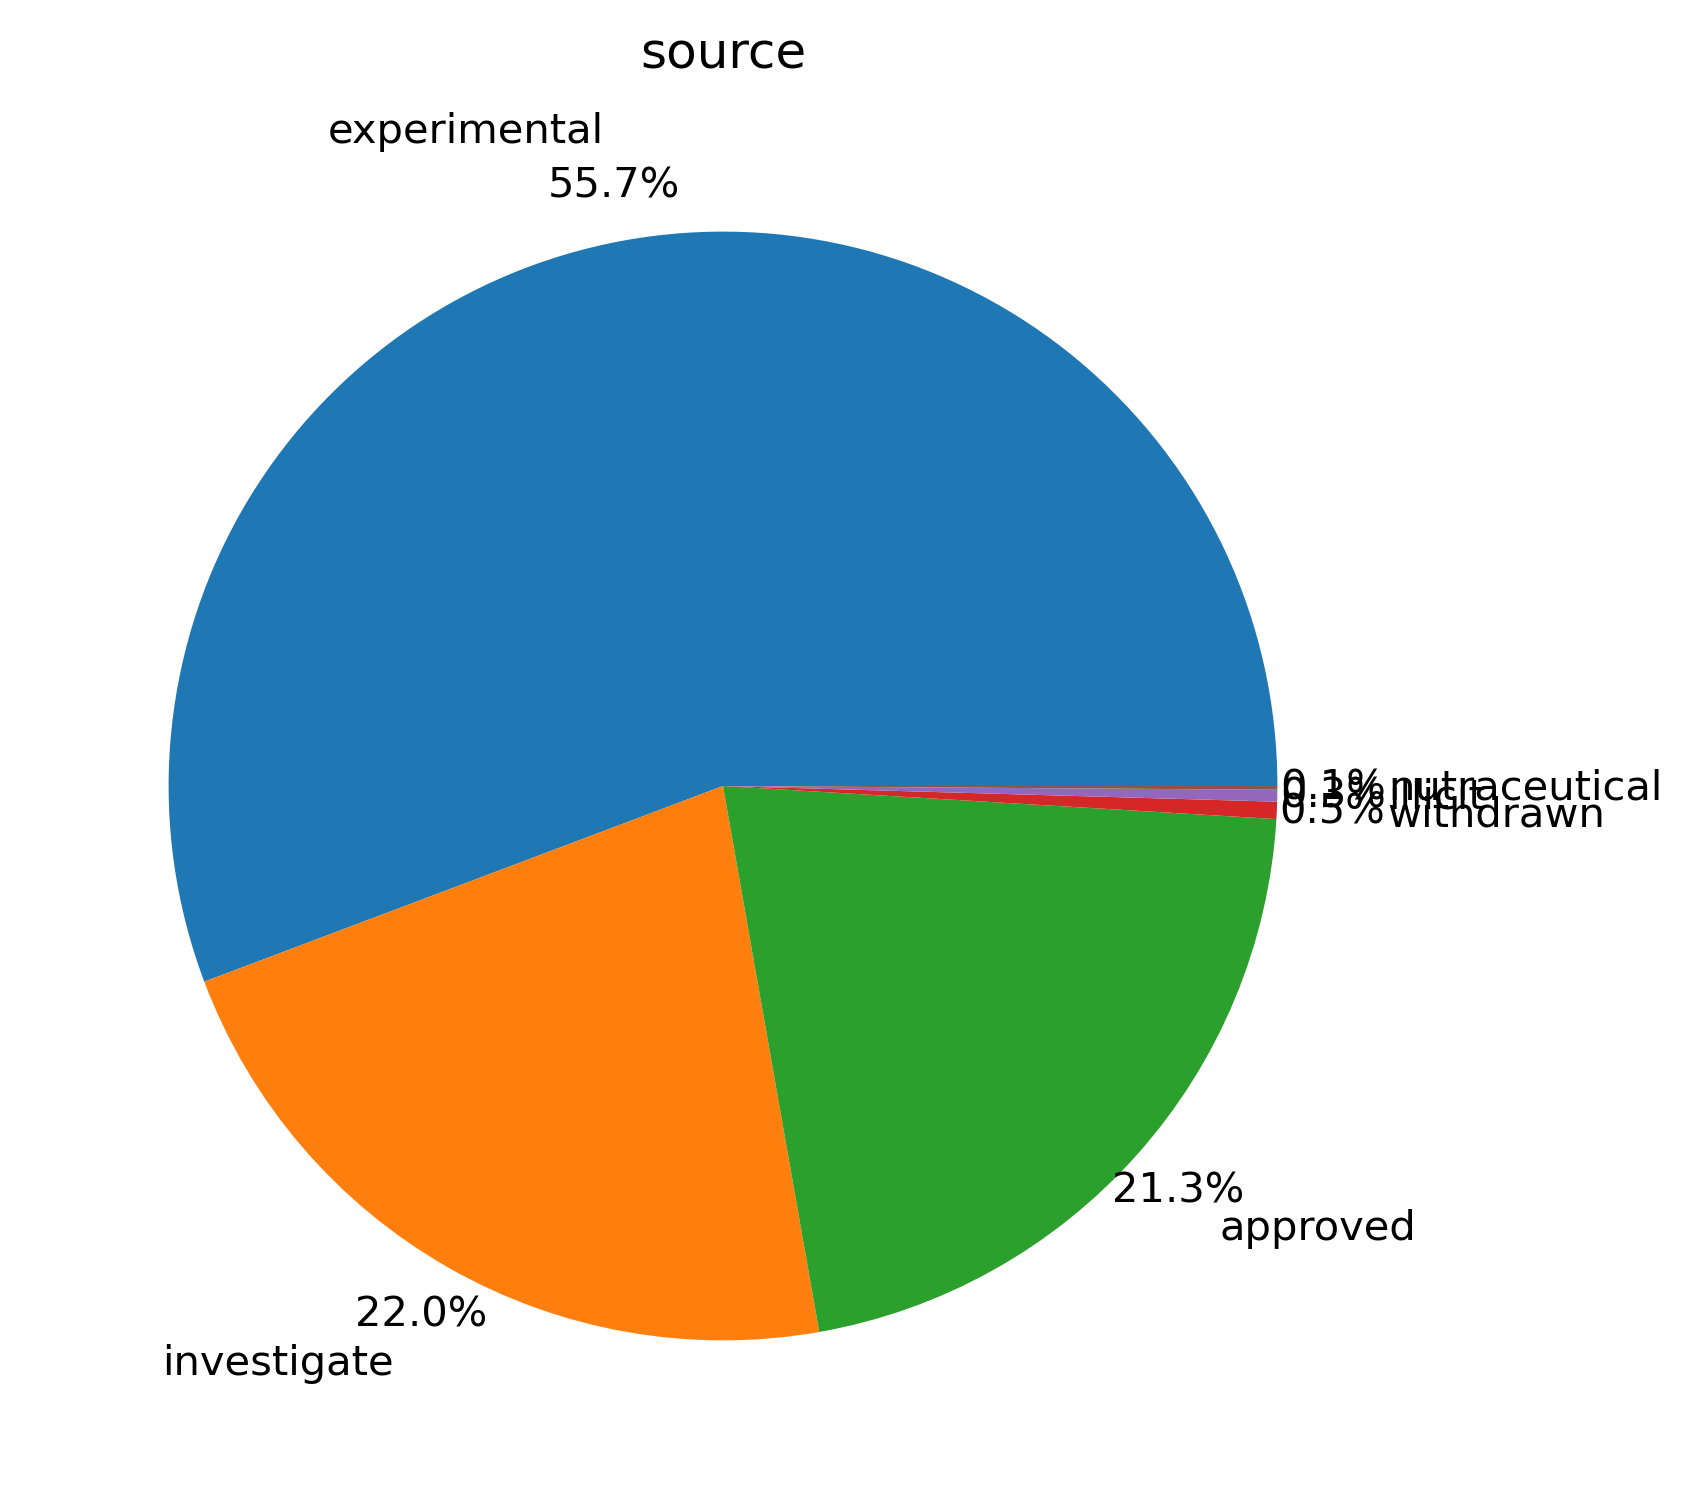

In [30]:
key = 'source'
def draw_pie(key, df):
        grades_labels = list(df[key].value_counts().index)
        print(grades_labels)
        grades_nums = df[key].value_counts().values
        plt.figure(figsize=(12,6),dpi=300)
        plt.pie(grades_nums, labels = grades_labels, autopct = '%1.1f%%',
        pctdistance = 1.1,labeldistance = 1.2)
        plt.title(key)
        plt.show()
draw_pie(key, df_drug_merge)